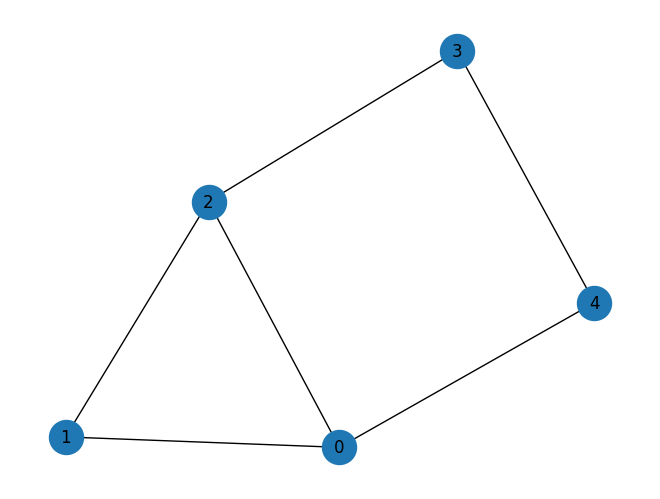

In [22]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [23]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """
    Converting a graph to Pauli List
    This function doing inverse of 'build_max_cut_graph'
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis[::1]), weight))
    return pauli_list
max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost function Hamiltonian: ", cost_hamiltonian)

Cost function Hamiltonian:  SparsePauliOp(['ZZIII', 'ZIZII', 'ZIIIZ', 'IZZII', 'IIZZI', 'IIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


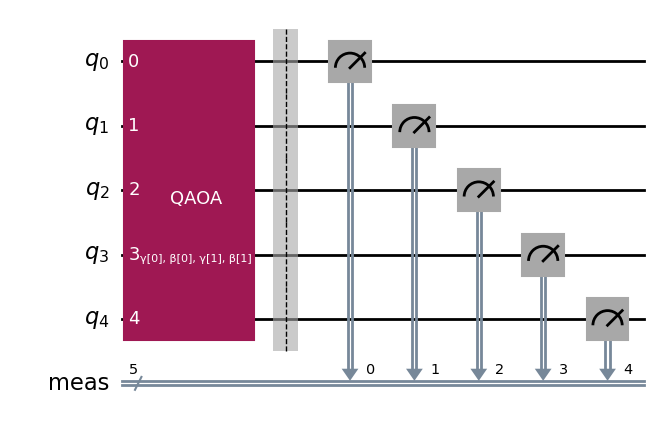

In [24]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [25]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

<IBMBackend('ibm_brisbane')>


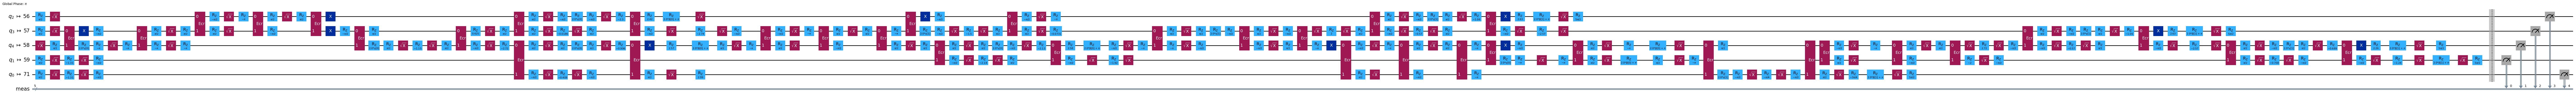

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

pm = generate_preset_pass_manager(optimization_level=3, 
                                  backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [27]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [28]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transforming observable defined on virtual qubits to an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [29]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method = "COBYLA",
        tol=1e-2,
    )
    print(result)
session.cancel()

qiskit_runtime_service.check_pending_jobs:WARNING:2024-12-30 19:29:38,679: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cxr0ypt082700083yrkg', 'estimator')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

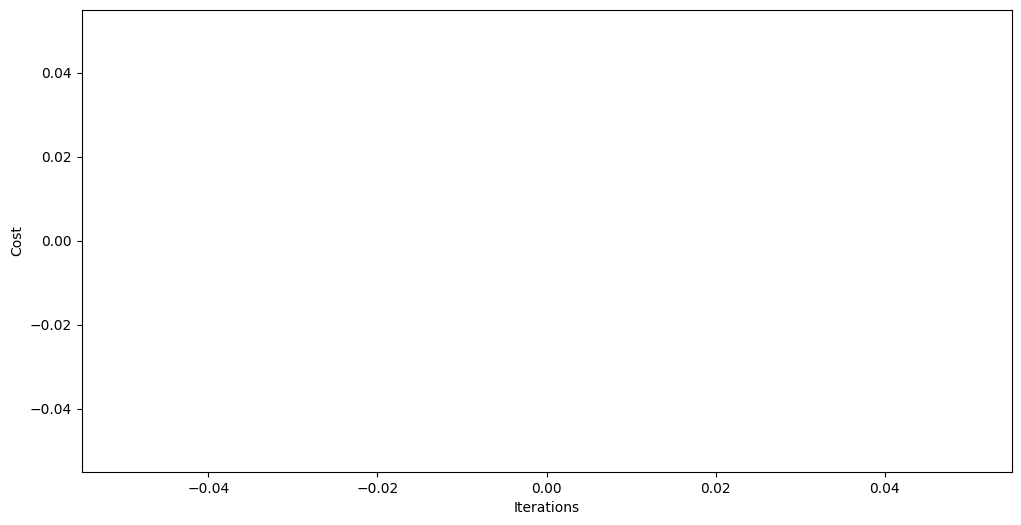

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

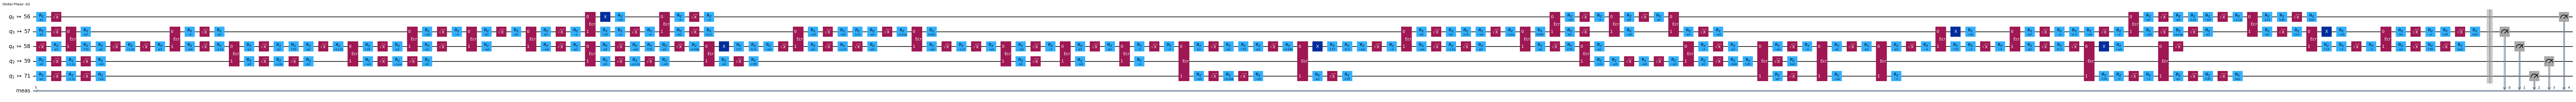

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots= 10000

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{1: 0.0185, 21: 0.0335, 10: 0.0443, 18: 0.0576, 26: 0.0715, 20: 0.055, 27: 0.0394, 5: 0.0726, 13: 0.0663, 29: 0.0263, 28: 0.0152, 22: 0.0306, 9: 0.0278, 11: 0.0619, 15: 0.0285, 23: 0.0234, 4: 0.0354, 0: 0.0096, 25: 0.0226, 31: 0.0138, 19: 0.0214, 7: 0.0176, 30: 0.0164, 12: 0.0213, 6: 0.0288, 14: 0.0226, 2: 0.0193, 8: 0.0197, 17: 0.0207, 24: 0.0181, 16: 0.0255, 3: 0.0148}


In [13]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring: ", most_likely_bitstring)

Result bitstring:  [1, 0, 1, 0, 0]


C:\Users\fmaul\AppData\Local\Temp\ipykernel_28616\3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


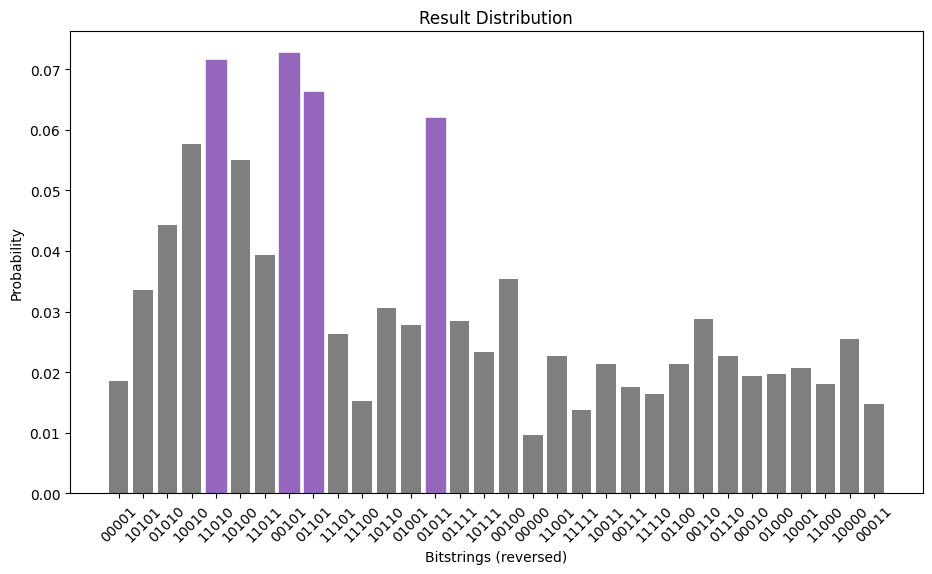

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

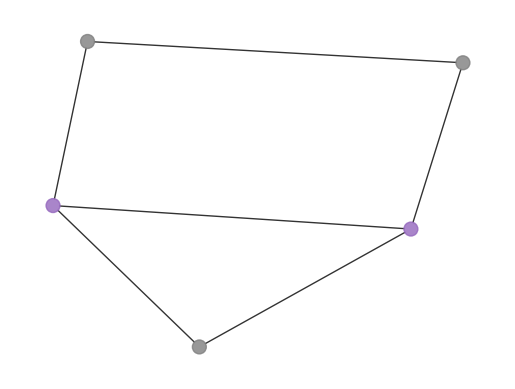

In [16]:
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

plot_result(graph, most_likely_bitstring)

In [17]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in graph.edge_list())

cut_value = evaluate_sample(most_likely_bitstring, graph)
print("Cut value: ", cut_value)

Cut value:  4


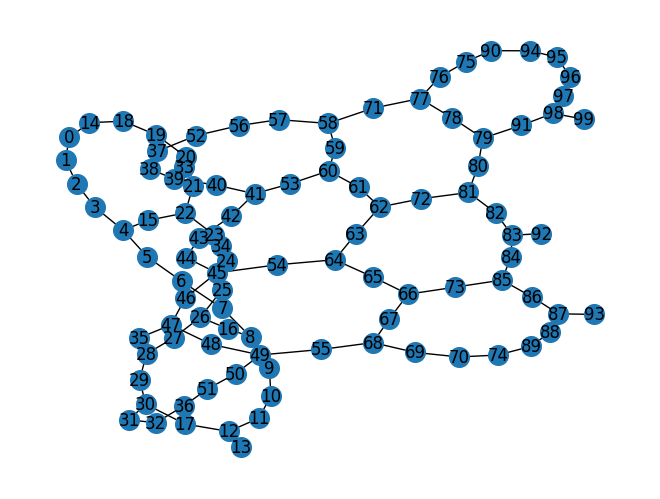

In [28]:
n = 100
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

In [29]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)
cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian: ", cost_hamiltonian_100)

Cost Function Hamiltonian:  SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII

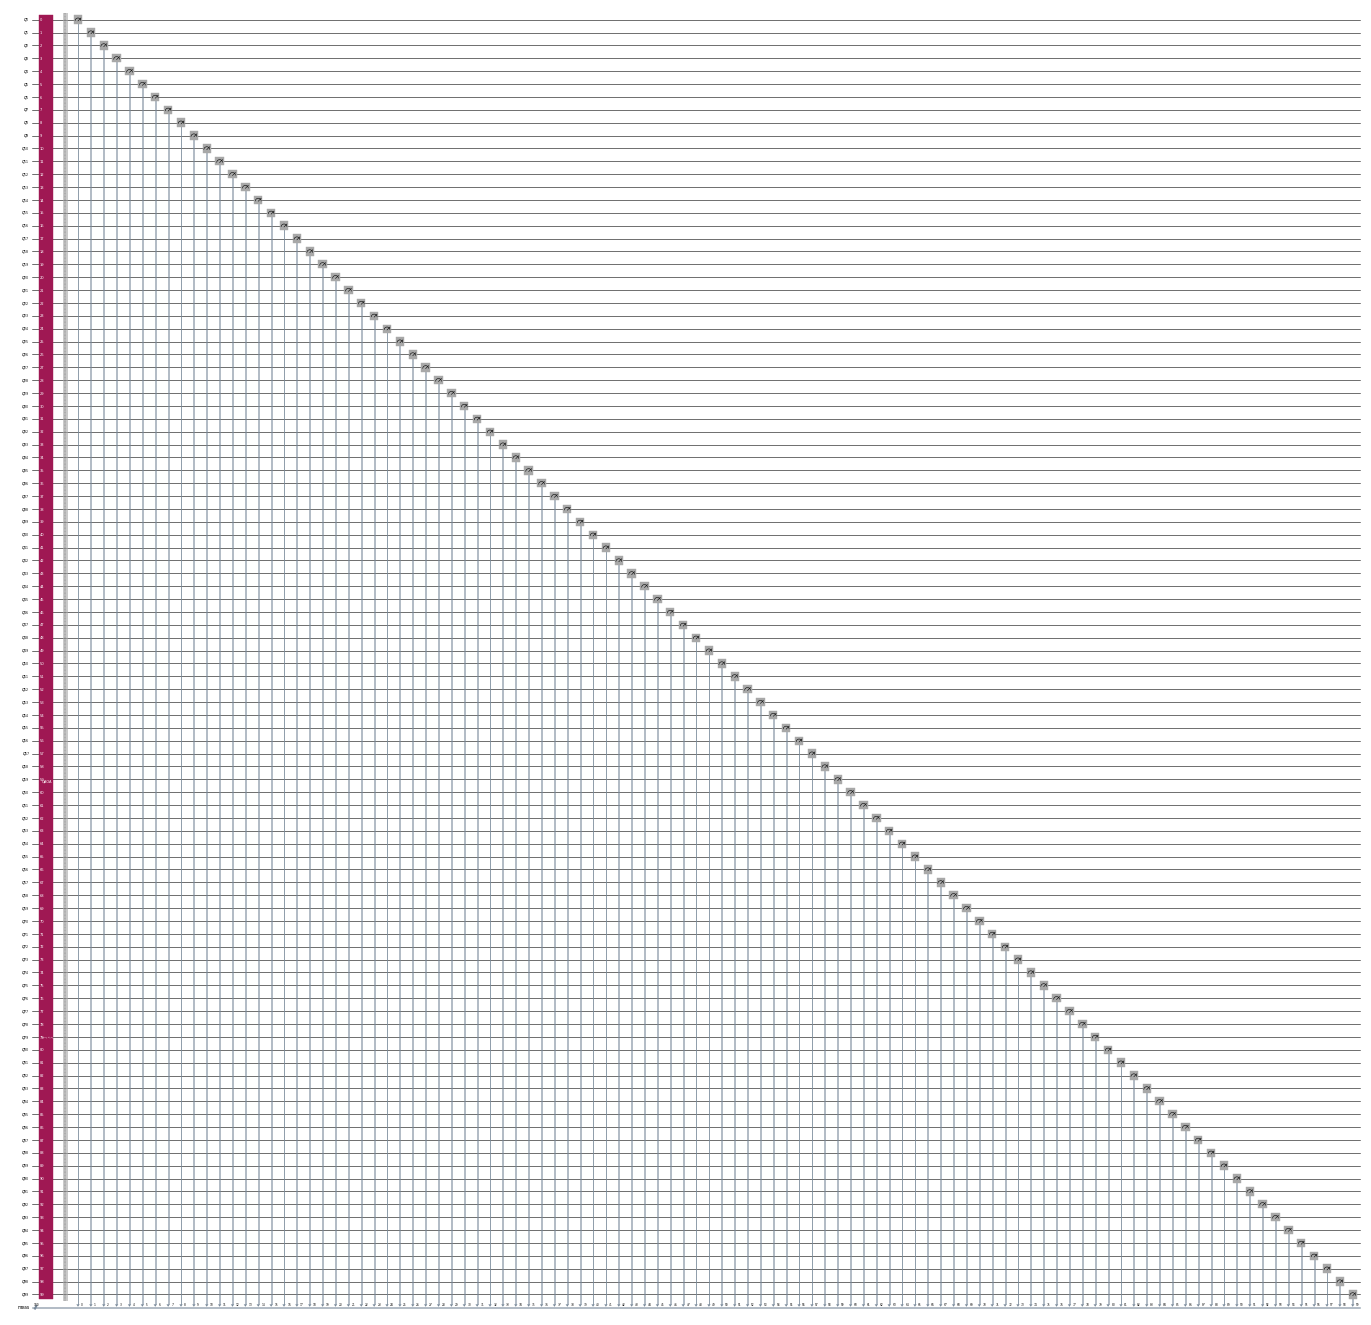

In [30]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

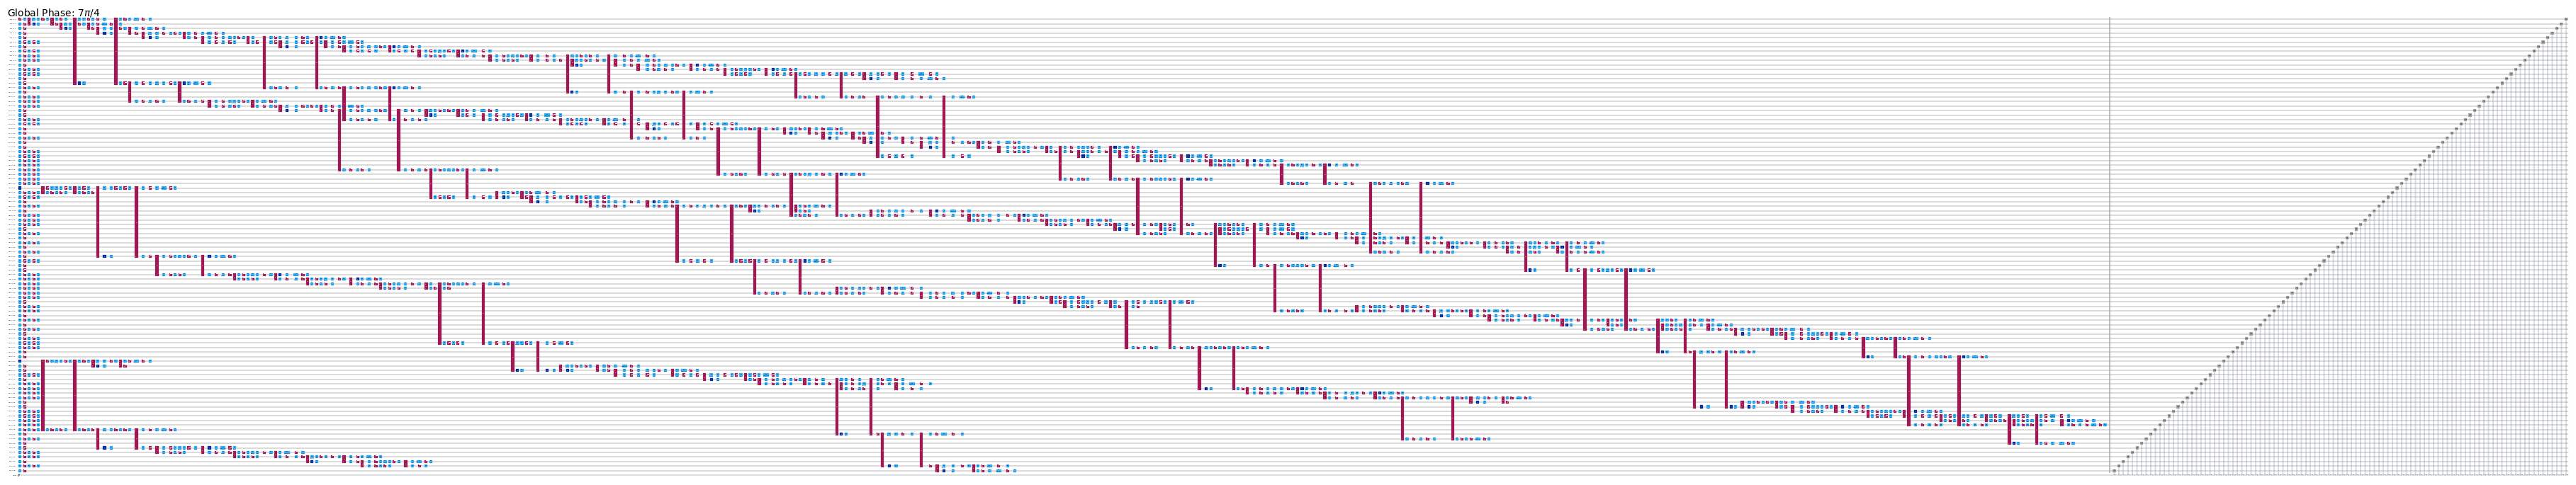

In [32]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

In [20]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta]

objective_func_vals = []
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

session.cancel()

NameError: name 'np' is not defined

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()


NameError: name 'session' is not defined